In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from utils import *

import xgboost as xgb

seed=42
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/submission'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/final_y.csv'),
 PosixPath('data/xgb_FE_best.model'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/train_no_att_time.csv'),
 PosixPath('data/validation'),
 PosixPath('data/val_idxs.p'),
 PosixPath('data/train_day9_3to16_nextclick_FE.feather'),
 PosixPath('data/train_day7_3to16_FE.feather'),
 PosixPath('data/mean_enc_df'),
 PosixPath('data/test_nextclick_FE.feather'),
 PosixPath('data/train_day7_3to16_nextclick.feather'),
 PosixPath('data/test_nextclick.feather'),
 PosixPath('data/xgb_FE_best_more.model'),
 PosixPath('data/train_day9_3to16_nextclick.feather'),
 PosixPath('data/test.csv'),
 PosixPath('data/train_day8_3to16_nextclick_FE.feather'),
 PosixPath('data/final_train.feather'),
 PosixPath('data/train_day8_3to16_nextclick.feather'),
 PosixPath('data/val_idxs_3.p')]

In [2]:
# def metric(rf,X_val,y_val):
#     y_val_pred = rf.predict_proba(X_val)[:,1]
#     return roc_auc_score(y_val,y_val_pred)

# def permutation_importances(rf,X_val,y_val,metric):
#     baseline = metric(rf,X_val,y_val)
#     imp=[]
#     for col in X_val.columns:
#         save = X_val[col].copy()
#         X_val[col] = np.random.permutation(X_val[col])
#         m = metric(rf,X_val,y_val)
#         print(f'Score after {col} perm: {m:.5f}')
#         X_val[col] = save
#         imp.append(baseline-m)
#     return np.array(imp)



In [2]:
cols_to_drop=['is_attributed','ip','day','device']
train_filename = 'train_day8_3to16_nextclick_FE.feather'

# Sample run

In [3]:
val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val2.feather',
 'data/validation/val1.feather',
 'data/validation/val0.feather']

In [4]:
train_filename = 'train_day8_3to16_nextclick_FE.feather'
train_df,y_train = get_train(cols_to_drop,train_filename,20000000)

In [5]:
# params = {'colsample_bytree': 0.7, 
#           'eval_metric': 'auc', 
#           'learning_rate': 0.1, 
#           'max_depth': 4, 
#           'min_child_weight': 100, 
#           'objective': 'binary:logistic', 
#           'seed': seed, 
#           'subsample': 0.9500000000000001,
#           'scale_pos_weight': 100,
#           'tree_method': 'gpu_hist'}

# params = {'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 132, 'min_child_weight': 184, 'objective': 'binary:logistic', 'scale_pos_weight': 143, 'seed': 42, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
dtrain = xgb.DMatrix(train_df,y_train)
del train_df,y_train
gc.collect()

val_names=['data/validation/val2.feather','data/validation/val0.feather']
for i in val_names:           
    val_df,y_val = get_val_by_name(cols_to_drop,i)
    dval = xgb.DMatrix(val_df,y_val)
    
    del val_df,y_val
    gc.collect()

    watchlist = [(dtrain, 'train'), (dval, 'valid')]
    xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                      verbose_eval=50, 
                      early_stopping_rounds=40)

    train_pred = xgb_model.predict(dtrain,ntree_limit=xgb_model.best_ntree_limit)
    val_pred = xgb_model.predict(dval,ntree_limit=xgb_model.best_ntree_limit)

    train_loss = roc_auc_score(dtrain.get_label(),train_pred)
    val_loss = roc_auc_score(dval.get_label(),val_pred)
    print(f'Train AUC: {train_loss}. Val AUC: {val_loss}. Best ite: {xgb_model.best_ntree_limit}')

    del dval
    xgb_model.__del__()
    gc.collect()
    

[0]	train-auc:0.977835	valid-auc:0.965485
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.989116	valid-auc:0.980567
[100]	train-auc:0.991872	valid-auc:0.980369
Stopping. Best iteration:
[54]	train-auc:0.989416	valid-auc:0.980625

Train AUC: 0.989416309928855. Val AUC: 0.9806252720101168. Best ite: 55


MemoryError: 

Train AUC: 0.9896448076706793. Val AUC: 0.9798879198763614. Best ite: 62

Train AUC: 0.989416309928855. Val AUC: 0.9806252720101168. Best ite: 55

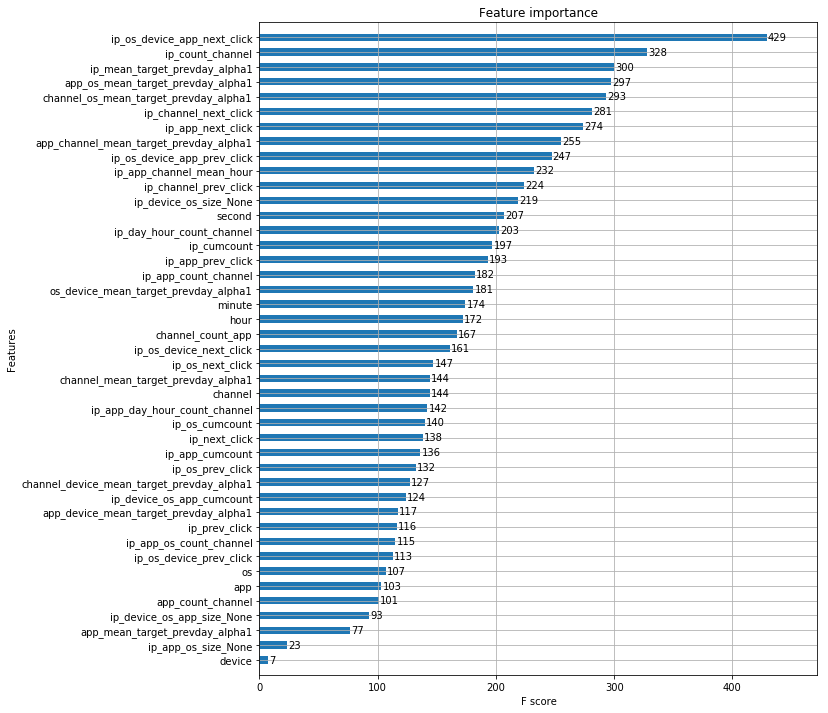

In [11]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_model,ax=ax,height=.5)

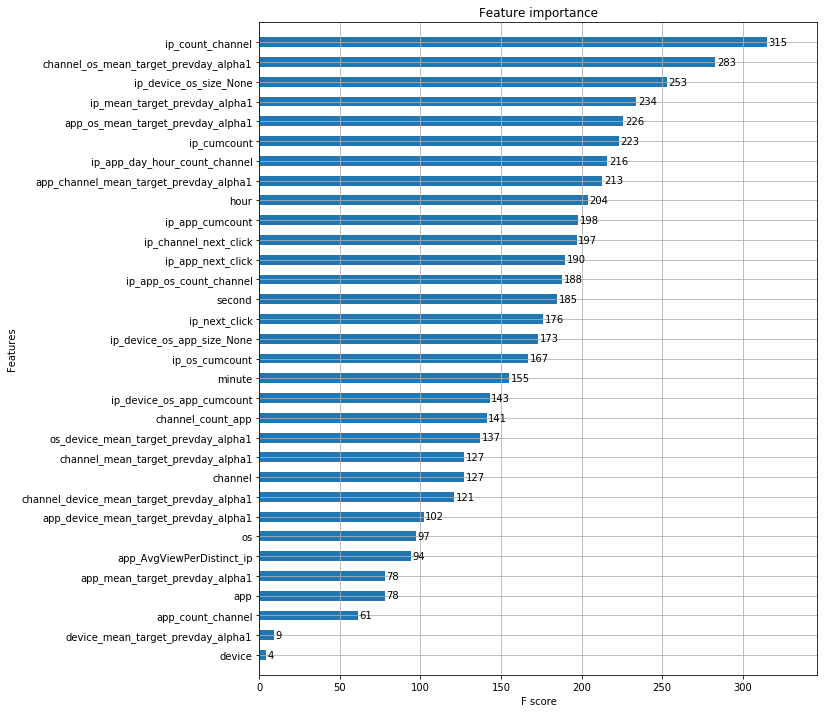

# Hypertuning

In [3]:
train_df,y_train = get_train(cols_to_drop,train_filename,10000000)

In [7]:
print(train_df.shape)
print(y_train.shape)

(10000000, 42)
(10000000,)


In [4]:
val_name = 'data/validation/val2.feather'
val_df,y_val = get_val_by_name(cols_to_drop,val_name)
print(val_df.shape)
dtrain = xgb.DMatrix(train_df,y_train)
dval = xgb.DMatrix(val_df,y_val)

del train_df,y_train,val_df,y_val
gc.collect()

(14515629, 42)


413

In [5]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

val_losses=[]
ites=[]



def score(params):
    print("Training with params: ")
    print(params)



    watchlist = [(dtrain, 'train'), (dval, 'valid')]
    xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                      verbose_eval=False, 
                      early_stopping_rounds=80)

    train_pred = xgb_model.predict(dtrain,ntree_limit=xgb_model.best_ntree_limit)
    val_pred = xgb_model.predict(dval,ntree_limit=xgb_model.best_ntree_limit)

    train_loss = roc_auc_score(dtrain.get_label(),train_pred)
    val_loss = roc_auc_score(dval.get_label(),val_pred)
    val_losses.append(val_loss)
    ites.append(xgb_model.best_ntree_limit)
    print(f'Train AUC: {train_loss}. Val AUC: {val_loss}. Best ite: {xgb_model.best_ntree_limit}')

    xgb_model.__del__()

    gc.collect()
    
    
    return {'loss': val_loss, 'status': STATUS_OK}

def optimize(space,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best

In [ ]:

space = {
    #'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
#     'max_depth': hp.choice('max_depth', np.arange(5, 10, dtype=int)),
    'subsample': hp.quniform('subsample', 0.65, .9, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, .75, 0.05),
    'gamma': hp.quniform('gamma', 0, 0.7, 0.05),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(115,139, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(150,250, dtype=int)),
    'scale_pos_weight': hp.choice('scale_pos_weight', np.arange(140,175, dtype=int)),
    'learning_rate': 0.2,
    'eval_metric': 'auc', 
    'objective': 'binary:logistic', 
    'seed': seed,'tree_method':'gpu_hist'
}
best_hyperparams = optimize(space,max_evals=100)
print("The best hyperparameters are: ")
print(best_hyperparams)

Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 135, 'min_child_weight': 245, 'objective': 'binary:logistic', 'scale_pos_weight': 166, 'seed': 42, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9904414675648162. Val AUC: 0.9788559172278635. Best ite: 49
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.45, 'learning_rate': 0.2, 'max_leaf_nodes': 131, 'min_child_weight': 228, 'objective': 'binary:logistic', 'scale_pos_weight': 158, 'seed': 42, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
Train AUC: 0.9899310780970436. Val AUC: 0.9794407389750257. Best ite: 43
Training with params: 
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 118, 'min_child_weight': 227, 'objective': 'binary:logistic', 'scale_pos_weight': 155, 'seed': 42, 'subsample': 0.75, 'tree_metho

Train AUC: 0.989389129705155. Val AUC: 0.9791256917708383. Best ite: 41
Training with params: 
{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 119, 'min_child_weight': 172, 'objective': 'binary:logistic', 'scale_pos_weight': 160, 'seed': 42, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.990793311584938. Val AUC: 0.97949115368076. Best ite: 51
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 127, 'min_child_weight': 196, 'objective': 'binary:logistic', 'scale_pos_weight': 156, 'seed': 42, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
Train AUC: 0.9898145988067961. Val AUC: 0.9790397046460271. Best ite: 43
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.35000000000000003, 'learning_rate': 0.2, 'max_leaf_nodes': 135, 'min_child_weight': 167, 'objective': 'binary:logistic', 'scale_pos_

{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 123, 'min_child_weight': 226, 'objective': 'binary:logistic', 'scale_pos_weight': 153, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9905307076810729. Val AUC: 0.9798359548009582. Best ite: 50


{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 132, 'min_child_weight': 184, 'objective': 'binary:logistic', 'scale_pos_weight': 143, 'seed': 42, 'subsample': 0.8, 'tree_method': 'gpu_hist'}

Train AUC: 0.9908514539139269. Val AUC: 0.9797423487683407. Best ite: 52


{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 122, 'min_child_weight': 190, 'objective': 'binary:logistic', 'scale_pos_weight': 162, 'seed': 42, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}

Train AUC: 0.9893706708928707. Val AUC: 0.9796582714397254. Best ite: 41


{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.35000000000000003, 'learning_rate': 0.2, 'max_leaf_nodes': 134, 'min_child_weight': 206, 'objective': 'binary:logistic', 'scale_pos_weight': 152, 'seed': 42, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}

Train AUC: 0.9901680741951226. Val AUC: 0.979653684423481. Best ite: 49

In [ ]:

# space = {
#     #'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
# #     'max_depth': hp.choice('max_depth', np.arange(5, 10, dtype=int)),
#     'subsample': hp.quniform('subsample', 0.5, .95, 0.05),
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.6, .95, 0.05),
#     'gamma': hp.quniform('gamma', 0, 1, 0.05),
#     'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(100,200, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(100,300, dtype=int)),
#     'scale_pos_weight': hp.choice('scale_pos_weight', np.arange(100,200, dtype=int)),
#     'learning_rate': 0.2,
#     'eval_metric': 'auc', 
#     'objective': 'binary:logistic', 
#     'seed': seed,'tree_method':'gpu_hist'
# }
# best_hyperparams = optimize(space,max_evals=400)
# print("The best hyperparameters are: ")
# print(best_hyperparams)

{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 137, 'min_child_weight': 234, 'objective': 'binary:logistic', 'scale_pos_weight': 174, 'seed': 42, 'subsample': 0.65, 'tree_method': 'gpu_hist'}

Train AUC: 0.9890734110516249. Val AUC: 0.9710285760055137. Best ite: 66



{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.4, 'learning_rate': 0.2, 'max_leaf_nodes': 132, 'min_child_weight': 255, 'objective': 'binary:logistic', 'scale_pos_weight': 171, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9883986898291575. Val AUC: 0.9709192250836084. Best ite: 59



{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.2, 'max_leaf_nodes': 117, 'min_child_weight': 102, 'objective': 'binary:logistic', 'scale_pos_weight': 142, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9890574056615543. Val AUC: 0.9708889777453811. Best ite: 66


{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 136, 'min_child_weight': 158, 'objective': 'binary:logistic', 'scale_pos_weight': 147, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9900232716267741. Val AUC: 0.970884543564802. Best ite: 73


{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.55, 'learning_rate': 0.2, 'max_leaf_nodes': 191, 'min_child_weight': 256, 'objective': 'binary:logistic', 'scale_pos_weight': 150, 'seed': 42, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}

Train AUC: 0.989775927707004. Val AUC: 0.9707834122560919. Best ite: 72

# Test prediction

In [3]:
val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val2.feather',
 'data/validation/val1.feather',
 'data/validation/val0.feather']

In [3]:
train_df,y_train = get_train(cols_to_drop,train_filename,2000000)

In [4]:
val_name = ['data/validation/val2.feather']
val_df,y_val=[],[]
for name in val_name:
    temp = get_val_by_name(cols_to_drop,name) 
    val_df.append(temp[0])
    y_val.append(temp[1])
    
final_df = pd.concat([train_df] + val_df,ignore_index=True)
final_y = pd.concat([y_train] + y_val,ignore_index=True)

del train_df,y_train,val_df,y_val
gc.collect()

406

In [5]:
gc.collect()

308

In [7]:
# final_df.to_feather(PATH/'final_train.feather')
# final_y.Series.to_csv(PATH/'final_y.csv',index=False)

In [ ]:
# final_df = pd.read_feather(PATH/'final_train.feather')
# final_y = pd.Series.read_csv(PATH/'final_y.csv')

In [6]:
ratio=2
# params = {'colsample_bytree': 0.7000000000000001, 
#           'eval_metric': 'auc', 
#           'gamma': 0.15000000000000002, 
#           'learning_rate': 0.2/ratio, 
#           'max_leaf_nodes': 137, 
#           'min_child_weight': 234, 
#           'objective': 'binary:logistic', 
#           'scale_pos_weight': 174, 
#           'seed': 42, 
#           'subsample': 0.65, 
#           'tree_method': 'gpu_hist'}
params = {'colsample_bytree': 0.65, 
          'eval_metric': 'auc', 
          'gamma': 0.6000000000000001, 
          'learning_rate': 0.2/ratio, 
          'max_leaf_nodes': 123, 
          'min_child_weight': 226, 'objective': 'binary:logistic', 'scale_pos_weight': 153, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
n_ite = (50+1)*ratio

dtrain = xgb.DMatrix(final_df,final_y)

In [7]:
del final_df,final_y
gc.collect()

203

In [8]:
xgb_model = xgb.train(params, dtrain, n_ite,[(dtrain, 'train'), (dtrain, 'valid')],
                  verbose_eval=10)

[0]	train-auc:0.97392	valid-auc:0.97392
[10]	train-auc:0.978062	valid-auc:0.978062
[20]	train-auc:0.979621	valid-auc:0.979621
[30]	train-auc:0.981314	valid-auc:0.981314
[40]	train-auc:0.982801	valid-auc:0.982801
[50]	train-auc:0.984088	valid-auc:0.984088
[60]	train-auc:0.98508	valid-auc:0.98508
[70]	train-auc:0.985947	valid-auc:0.985947
[80]	train-auc:0.986552	valid-auc:0.986552
[90]	train-auc:0.98703	valid-auc:0.98703
[100]	train-auc:0.987451	valid-auc:0.987451
[101]	train-auc:0.987489	valid-auc:0.987489


In [9]:
del dtrain
gc.collect()

261

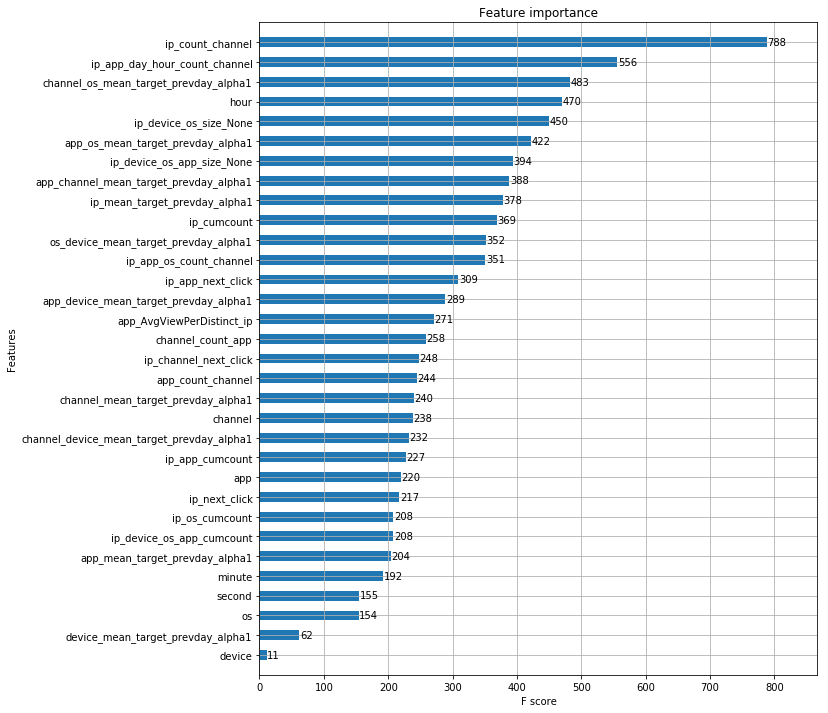

In [9]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_model,ax=ax,height=.5)

In [10]:
xgb_model.save_model(str(PATH/'xgb_FE_best_more.model'))
xgb_model.__del__()
gc.collect()

330

In [3]:

xgb_model = xgb.Booster({'nthread': 8})  # init model
xgb_model.load_model(str(PATH/'xgb_FE_best_more.model'))  # load data


In [4]:
test = get_feather('test_nextclick_FE.feather')

test.drop(cols_to_drop[1:],axis=1,inplace=True)

test.shape

(18790469, 42)

In [5]:
dtest = xgb.DMatrix(test)

del test
gc.collect()

710

In [6]:
pred = xgb_model.predict(dtest)

In [7]:
sub = pd.read_csv(PATH/'sample_submission.csv')
sub.is_attributed = pred
sub.tail()

,click_id,is_attributed
18790464,18790464,0.127977
18790465,18790465,0.001474
18790466,18790467,0.015972
18790467,18790466,0.037256
18790468,18790468,0.002564


In [8]:
sub.to_csv(PATH/'submission'/'XGB_FE_day89_ratio2_more.csv',index=False)